In [1]:
# This demonstrates how to finetune a SatlasPretrain Sentinel-2 model on the EuroSAT classification task.

In [1]:
import io
import os
import torch
import zipfile
import requests
import torch.nn
import torchvision
from torch.utils.data import Dataset, DataLoader

import satlaspretrain_models

In [2]:
# Download the EuroSAT_RGB dataset.
# Only go through the downloading and unzipping process if it hasn't been done before.
if not os.path.exists('EuroSAT_RGB/'):
    # Download the EuroSAT_RGB dataset. This is a zip file.
    zip_file_url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'

    # Send a GET request to the EuroSAT_RGB Zenodo download URL.
    response = requests.get(zip_file_url)

    # Check if the request was successful.
    if response.status_code == 200:
        # Use BytesIO for the zip file content.
        zip_file = io.BytesIO(response.content)

        # Open the zip file. You should see the EuroSAT_RGB/ folder in this directory.
        with zipfile.ZipFile(zip_file) as zfile:
            # Extract all the contents into the current directory
            zfile.extractall('.')
            print("Zip file extracted successfully.")
    else:
        print(f"Failed to download the zip file. Status code: {response.status_code}")

In [3]:
# Gather the EuroSAT class names.
classes = os.listdir('EuroSAT_RGB/')

# Create a mapping from class label to a unique integer. For later visualization.
cls_to_int = {label: idx for idx, label in enumerate(set(classes))}
int_to_class = {v: k for k, v in cls_to_int.items()}
print("Classes mapped to integers:", cls_to_int)

Classes mapped to integers: {'Pasture': 0, 'Highway': 1, 'Residential': 2, 'Forest': 3, 'PermanentCrop': 4, 'SeaLake': 5, 'Industrial': 6, 'AnnualCrop': 7, 'HerbaceousVegetation': 8, 'River': 9}


In [4]:
# Define a dataset class that takes in the path to the EuroSAT_RGB path and returns datapoints,
# each with a torch tensor containing the image data and a corresponding target class. 
class Dataset(Dataset):
    def __init__(self, dataset_path, val=False):

        self.datapoints = []

        # The subdirectories in the dataset folder are named by class.
        classes = os.listdir(dataset_path)

        # Create a mapping from class label to a unique integer.
        cls_to_int = {label: idx for idx, label in enumerate(set(classes))}
        
        # For each class, use 80% of the images for training and the rest for validation.
        for cls in classes:
            cls_int = cls_to_int[cls]
            cls_imgs = os.listdir(dataset_path + '/' + cls + '/')

            if val:
                cls_datapoints = [(dataset_path + '/' + cls + '/' + img, cls_int) for img in cls_imgs[2400:]]
            else:
                cls_datapoints = [(dataset_path + '/' + cls + '/' + img, cls_int) for img in cls_imgs[:2400]]

            self.datapoints += cls_datapoints
        print("Loaded ", len(self.datapoints), " datapoints.")

    def __getitem__(self, idx):
        img_path, cls_int = self.datapoints[idx]
        img = torchvision.io.read_image(img_path)  # load image directly into a [3, 64, 64] tensor
        img = img.float() / 255  # normalize input to be between 0-1
        target = torch.tensor(cls_int)  # convert class index into a torch tensor
        return img, target

    def __len__(self):
        return len(self.datapoints)

In [5]:
# Experiment arguments.
device = torch.device('cpu')
num_epochs = 1000
criterion = torch.nn.CrossEntropyLoss()
val_step = 10  # evalaute every val_step epochs

In [6]:
# Initialize the train and validation datasets.
train_dataset = Dataset('EuroSAT_RGB/')
val_dataset = Dataset('EuroSAT_RGB/', val=True)

# Dataloaders.
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

Loaded  23600  datapoints.
Loaded  3400  datapoints.


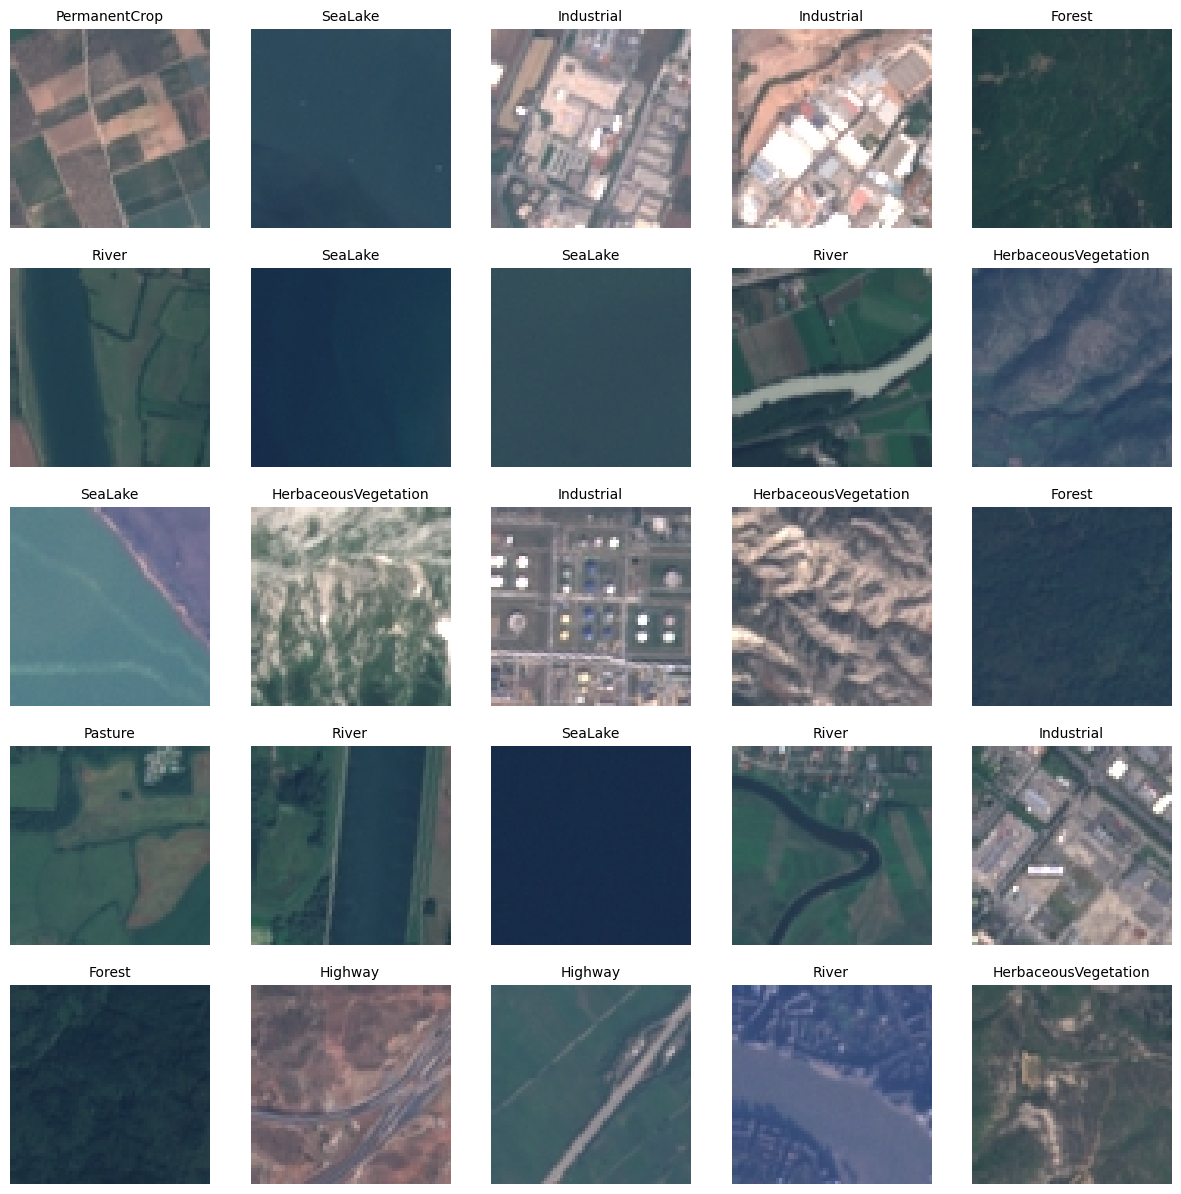

In [7]:
# Visualize a couple datapoints, pulled randomly from the training set.
import random
import matplotlib.pyplot as plt

shuffled_indices = torch.randperm(train_dataset.__len__()).tolist()
random_samples = [train_dataset[x] for x in shuffled_indices]

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    data, target = random_samples[i]
    
    image = data.cpu().numpy()
    target = int(target.cpu().numpy())    
    image = image.transpose(1, 2, 0)

    ax.set_title(int_to_class[target], fontsize=10)
    ax.imshow(image)
    ax.axis('off')

plt.show()

In [8]:
# Initialize a pretrained model, using the SatlasPretrain single-image Swin-v2-Base Sentinel-2 image model weights
# with a classification head with num_categories=10, since EuroSAT has 10 classes.
weights_manager = satlaspretrain_models.Weights()
model = weights_manager.get_pretrained_model("Sentinel2_SwinB_SI_RGB", fpn=True, head=satlaspretrain_models.Head.CLASSIFY, 
                                                num_categories=10, device='cpu')
model = model.to(device)

In [9]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# Training loop.
for epoch in range(num_epochs):
    print("Starting Epoch...", epoch)

    for data, target in train_dataloader:
        data = data.to(device)
        target = target.to(device)

        output, loss = model(data, target)
        print("Train Loss = ", loss)

        loss.backward()
        optimizer.step()

    # Validation.
    if epoch % val_step == 0:
        model.eval()

        for val_data, val_target in val_dataloader:
            val_data = val_data.to(device)
            val_target = val_target.to(device)

            val_output, val_loss = model(val_data, val_target)

            val_accuracy = (val_output.argmax(dim=1) == val_target).float().mean().item()
            print("Validation accuracy = ", val_accuracy)

Starting Epoch... 0
Train Loss =  tensor(3.5067, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.7136, grad_fn=<MeanBackward0>)
Train Loss =  tensor(3.0775, grad_fn=<MeanBackward0>)
Train Loss =  tensor(1.9936, grad_fn=<MeanBackward0>)
Train Loss =  tensor(1.7020, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.3398, grad_fn=<MeanBackward0>)
Train Loss =  tensor(3.2137, grad_fn=<MeanBackward0>)
Train Loss =  tensor(1.7092, grad_fn=<MeanBackward0>)
Train Loss =  tensor(3.1018, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.1248, grad_fn=<MeanBackward0>)
Train Loss =  tensor(1.8069, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.6953, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.4503, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.9763, grad_fn=<MeanBackward0>)
Train Loss =  tensor(1.9773, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.5786, grad_fn=<MeanBackward0>)
Train Loss =  tensor(2.8430, grad_fn=<MeanBackward0>)
Train Loss =  tensor(3.1325, grad_fn=<MeanBackward0>)
Train Lo

KeyboardInterrupt: 